# Using Reinforcement Learning to Control the Rocket Hopper Demonstrator


# Reinforcement Learning Algorithm  - DDPG


# Discussion and Technical Details

## Physical Simulation

### Description

The Rocket-Hopper Demonstrator only has 1 thruster that has no degree of gimballing, meaning that the only control parameter is the throttling of the engine. The thrust produced is a function of the mass flow that is allowed into the nozzle through the main valve. Therefore, the agent will have to control how open or closed the valve is.

At the **start** of the simulation, the demonstrator is an altitude of *0 m* above the ground with an initial velocity of *0 m/s*. The objective is that the Rocket Hopper is capable of launching, staying at a specific altitude for a determined number of seconds, and then smoothly lands again.

### Limitations

- The atmosphere is neglected for the control of the agent. Even though the test campaign will occur within an enclosed building with no wind or gusts, there is still an aerodynamic force to be considered when 

- It is directed that the valve opens and closes instantaneously, when it is known that the valve has a characteristic opening and closing time for each. 

### Implementation

The agent receives TBD observations at each timestep which are floating point values associated with the position, velocity and acceleration. 

The agent then acts and choses for each timestep, among TBD possible actions. 

# General Settings

Import Libraries that are used in the Reinforcement Learning algorithm

In [11]:
import gym # works only until version 0.12
import torch
from torch import nn                # needed for building neural networks
import torch.nn.functional as F     # needed for activation functions
import torch.optim as opt           # needed for optimisation
from tqdm import tqdm_notebook as tqdm
import random
from copy import copy, deepcopy
from collections import deque
import numpy as np
print("Using torch version: {}".format(torch.__version__))

Using torch version: 2.1.1+cpu


### Hyperparameter Settings

The configuration initially follows the [supplementary information section](https://arxiv.org/pdf/1509.02971.pdf?ref=blog.paperspace.com) of the DDPG paper in page 11.

In [12]:
BUFFER_SIZE=1000000     # Buffer size of 1 million entries
BATCH_SIZE=64   # Sampling from memory - This can be 128 for more complex tasks such as Hopper
GAMMA=0.9
TAU=0.001       #Target Network HyperParameters (soft update)
LRA=0.0001      #LEARNING RATE - ACTOR
LRC=0.001       #LEARNING RATE - CRITIC
H1=400   #neurons of 1st layers
H2=300   #neurons of 2nd layers

MAX_EPISODES=50000  #number of episodes of the training
MAX_STEPS=200       #max steps to finish an episode. An episode breaks early if some break conditions are met (like too much
                    #amplitude of the joints angles or if a failure occurs)

buffer_start = 100
epsilon = 1
epsilon_decay = 1./100000 #this is ok for a simple task like inverted pendulum, but maybe this would be set to zero for more
                     #complex tasks like Hopper; epsilon is a decay for the exploration and noise applied to the action is 
                     #weighted by this decay. In more complex tasks we need the exploration to not vanish so we set the decay
                     #to zero.
PRINT_EVERY = 10 #Print info about average reward every PRINT_EVERY

ENV_NAME = "Pendulum-v0" # For the hopper put "Hopper-v2" 
#check other environments to play with at https://gym.openai.com/envs/

### Replay Buffer
Implement a simple replay buffer without priority

In [13]:
class replayBuffer(object):
    def __init__(self, buffer_size, name_buffer=''):
        self.buffer_size=buffer_size  #choose buffer size
        self.num_exp=0
        self.buffer=deque()

    def add(self, s, a, r, t, s2):
        experience=(s, a, r, t, s2)
        if self.num_exp < self.buffer_size:
            self.buffer.append(experience)
            self.num_exp +=1
        else:
            self.buffer.popleft()
            self.buffer.append(experience)

    def size(self):
        return self.buffer_size

    def count(self):
        return self.num_exp

    def sample(self, batch_size):
        if self.num_exp < batch_size:
            batch=random.sample(self.buffer, self.num_exp)
        else:
            batch=random.sample(self.buffer, batch_size)

        s, a, r, t, s2 = map(np.stack, zip(*batch))

        return s, a, r, t, s2

    def clear(self):
        self.buffer = deque()
        self.num_exp=0

### GPU Setup 

For faster training

In [14]:
#set GPU for faster training
cuda = torch.cuda.is_available() #check for CUDA
device   = torch.device("cuda" if cuda else "cpu")
print("Job will run on {}".format(device))

Job will run on cpu


### Network Architecture

Network architecture is defined:

- **Actor** is composed of:
    - 3 FC (Fully-connected) Layers 
    - Hyperbolic tangent as the activation function -> Deals with a *-1,1* value range

- **Critic** is composed of:
    - Input: *state* & *action*
    - Output: Q-value after 3 FC Layers


In complex tasks, a *higher batch size* is required (128 instead of 64) and *batch normalisation layers* between input and hidden layers in both actor and critic.


In [15]:
def fanin_(size):
    fan_in = size[0]
    weight = 1./np.sqrt(fan_in)
    return torch.Tensor(size).uniform_(-weight, weight)

class Critic(nn.Module):
    def __init__(self, state_dim, action_dim, h1=H1, h2=H2, init_w=3e-3):
        super(Critic, self).__init__()
                
        ## Neural Network of 3 Fully-Connected Layers and ReLU Activation Function
        # FC1:       
        self.linear1 = nn.Linear(state_dim, h1)
        self.linear1.weight.data = fanin_(self.linear1.weight.data.size())
        # Uncomment to use batch normalisation
        #self.bn1 = nn.BatchNorm1d(h1)
        # FC2:    (Action dimensions added to hidden layer dimensions)
        self.linear2 = nn.Linear(h1+action_dim, h2)
        self.linear2.weight.data = fanin_(self.linear2.weight.data.size())
        # FC3  
        self.linear3 = nn.Linear(h2, 1)
        self.linear3.weight.data.uniform_(-init_w, init_w)
        # ReLU
        self.relu = nn.ReLU()
        
    def forward(self, state, action):
        """
        The state is passed through the neural network layers, as well as the action.
        """
        x = self.linear1(state)
        x = self.relu(x)
        x = self.linear2(torch.cat([x,action],1))
        x = self.relu(x)
        x = self.linear3(x)
        
        return x
    

class Actor(nn.Module): 
    def __init__(self, state_dim, action_dim, h1=H1, h2=H2, init_w=0.003):
        super(Actor, self).__init__()        

        ## Neural Network of 3 Fully-Connected Layers and TanH Activation Function
        # Uncomment to use batch normalisation:
        #self.bn0 = nn.BatchNorm1d(state_dim)
        # FC1:
        self.linear1 = nn.Linear(state_dim, h1)
        self.linear1.weight.data = fanin_(self.linear1.weight.data.size())
        # Uncomment to use batch normalisation:
        #self.bn1 = nn.BatchNorm1d(h1)
        # FC2:
        self.linear2 = nn.Linear(h1, h2)
        self.linear2.weight.data = fanin_(self.linear2.weight.data.size())
        # Uncomment to use batch normalisation:
        #self.bn2 = nn.BatchNorm1d(h2)
        # FC3:        
        self.linear3 = nn.Linear(h2, action_dim)
        self.linear3.weight.data.uniform_(-init_w, init_w)
        # ReLU + Hyperbolic Tangent Activation Function:
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        
    def forward(self, state):
        """
        The state is passed on through the neural network.
        """
        # state = self.bn0(state)
        x = self.linear1(state)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        x = self.tanh(x)
        return x
    
    def get_action(self, state):
        state  = torch.FloatTensor(state).unsqueeze(0).to(device)
        action = self.forward(state)
        return action.detach().cpu().numpy()[0]


### Exploration 

To ensure **exploration**, we have to add noise to the action. An **Ornstein-Uhlenbeck** process is chosen to add noise in a smooth way, suitable for continuous control tasks.

In [16]:
# Based on http://math.stackexchange.com/questions/1287634/implementing-ornstein-uhlenbeck-in-matlab
class OrnsteinUhlenbeckActionNoise:
    def __init__(self, mu=0, sigma=0.2, theta=.15, dt=1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

    def __repr__(self):
        return 'OrnsteinUhlenbeckActionNoise(mu={}, sigma={})'.format(self.mu, self.sigma)

Wrap state and action spaces

In [17]:
class NormalizedEnv(gym.ActionWrapper):
    """ Wrap action """

    def _action(self, action):
        act_k = (self.action_space.high - self.action_space.low)/ 2.
        act_b = (self.action_space.high + self.action_space.low)/ 2.
        return act_k * action + act_b

    def _reverse_action(self, action):
        act_k_inv = 2./(self.action_space.high - self.action_space.low)
        act_b = (self.action_space.high + self.action_space.low)/ 2.
        return act_k_inv * (action - act_b)

## Setup Training

Initialize:
- Environment
- Networks 
- Target networks
- Replay memory 
- Optimizers


In [18]:
torch.manual_seed(-1)       # So that results are reproducable, we always use the same seed

# Initialize environment:
env = NormalizedEnv(gym.make(ENV_NAME))

# Define dimensions of state and action
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

print("State dim: {}, Action dim: {}".format(state_dim, action_dim))

# Add noise:
noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(action_dim))

# Call architectures:
critic  = Critic(state_dim, action_dim).to(device)
actor = Actor(state_dim, action_dim).to(device)

target_critic  = Critic(state_dim, action_dim).to(device)
target_actor = Actor(state_dim, action_dim).to(device)

for target_param, param in zip(target_critic.parameters(), critic.parameters()):
    target_param.data.copy_(param.data)

for target_param, param in zip(target_actor.parameters(), actor.parameters()):
    target_param.data.copy_(param.data)
    

# Initialize the optimizer
q_optimizer  = opt.Adam(critic.parameters(),  lr=LRC)
policy_optimizer = opt.Adam(actor.parameters(), lr=LRA)

# Calculate the loss function
MSE = nn.MSELoss()

# Initialize replay memory 
memory = replayBuffer(BUFFER_SIZE)
# writer = SummaryWriter() #initialise tensorboard writer 


State dim: 3, Action dim: 1


### Iterate Through Episodes

MAX_EPISODES and MAX_STEPS parameters can be tuned according to the kind of the environment on which we are training the agent. 

In the case of a pendulum, we do not have a failure condition for each episode so it will always go through the max steps for each episode.

In a task where there is a failure condition, an agent will not go through all the steps (at least at the beginning, when it has not yet learned how to accomplish the task)

In [19]:
from matplotlib import pyplot as plt
from IPython.display import clear_output
%matplotlib inline

def subplot(R, P, Q, S):
    r = list(zip(*R))
    p = list(zip(*P))
    q = list(zip(*Q))
    s = list(zip(*S))
    clear_output(wait=True)
    
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,15))

    ax[0, 0].plot(list(r[1]), list(r[0]), 'r') #row=0, col=0
    ax[1, 0].plot(list(p[1]), list(p[0]), 'b') #row=1, col=0
    ax[0, 1].plot(list(q[1]), list(q[0]), 'g') #row=0, col=1
    ax[1, 1].plot(list(s[1]), list(s[0]), 'k') #row=1, col=1
    ax[0, 0].title.set_text('Reward')
    ax[1, 0].title.set_text('Policy loss')
    ax[0, 1].title.set_text('Q loss')
    ax[1, 1].title.set_text('Max steps')
    plt.show()

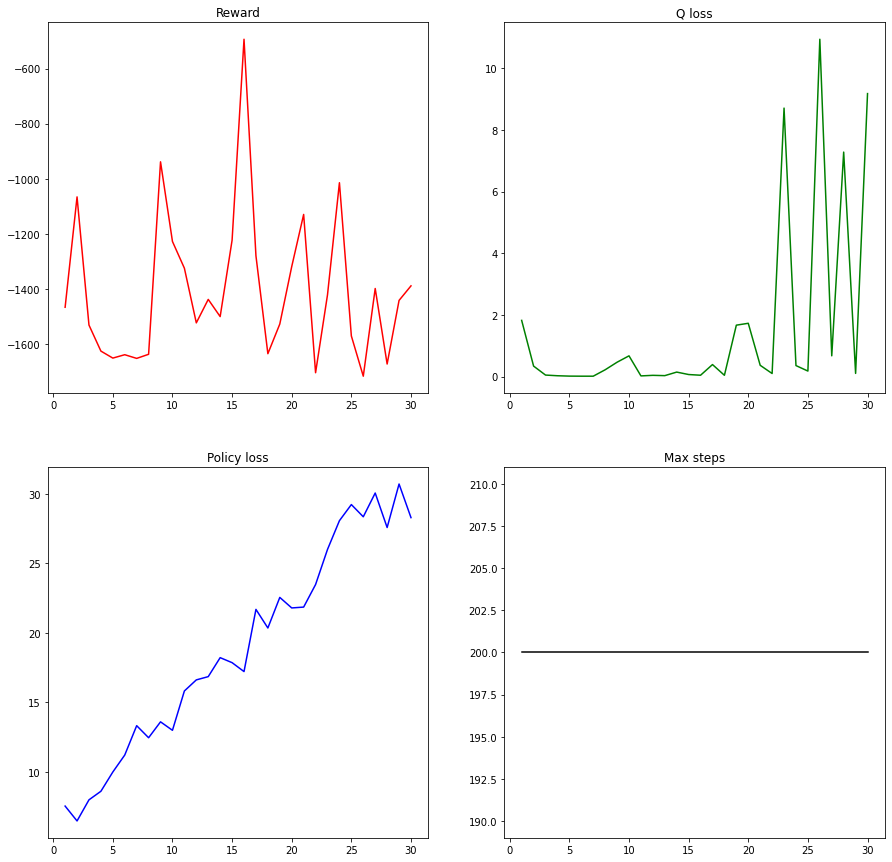

[    30 episode,     6000 total steps] average reward for past 10 iterations: -1446.013
Last model saved with reward: -493.39, at episode 16.


KeyboardInterrupt: 

In [20]:
plot_reward = []
plot_policy = []
plot_q = []
plot_steps = []


best_reward = -np.inf
saved_reward = -np.inf
saved_ep = 0
average_reward = 0
global_step = 0
#s = deepcopy(env.reset())

for episode in range(MAX_EPISODES):
    #print(episode)
    s = deepcopy(env.reset())
    #noise.reset()

    ep_reward = 0.
    ep_q_value = 0.
    step=0

    for step in range(MAX_STEPS):
        #loss=0
        global_step +=1
        epsilon -= epsilon_decay
        actor.eval()
        a = actor.get_action(s)
        actor.train()

        a += noise()*max(0, epsilon)
        a = np.clip(a, -1., 1.)
        s2, reward, terminal, info = env.step(a)


        memory.add(s, a, reward, terminal,s2)

        #keep adding experiences to the memory until there are at least minibatch size samples
        
        if memory.count() > buffer_start:
            s_batch, a_batch, r_batch, t_batch, s2_batch = memory.sample(BATCH_SIZE)

            s_batch = torch.FloatTensor(s_batch).to(device)
            a_batch = torch.FloatTensor(a_batch).to(device)
            r_batch = torch.FloatTensor(r_batch).unsqueeze(1).to(device)
            t_batch = torch.FloatTensor(np.float32(t_batch)).unsqueeze(1).to(device)
            s2_batch = torch.FloatTensor(s2_batch).to(device)
            
            
            #compute loss for critic
            a2_batch = target_actor(s2_batch)
            target_q = target_critic(s2_batch, a2_batch)
            y = r_batch + (1.0 - t_batch) * GAMMA * target_q.detach() #detach to avoid backprop target
            q = critic(s_batch, a_batch)
            
            q_optimizer.zero_grad()
            q_loss = MSE(q, y) 
            q_loss.backward()
            q_optimizer.step()
            
            #compute loss for actor
            policy_optimizer.zero_grad()
            policy_loss = -critic(s_batch, actor(s_batch))
            policy_loss = policy_loss.mean()
            policy_loss.backward()
            policy_optimizer.step()
            
            #soft update of the frozen target networks
            for target_param, param in zip(target_critic.parameters(), critic.parameters()):
                target_param.data.copy_(
                    target_param.data * (1.0 - TAU) + param.data * TAU
                )

            for target_param, param in zip(target_actor.parameters(), actor.parameters()):
                target_param.data.copy_(
                    target_param.data * (1.0 - TAU) + param.data * TAU
                )

        s = deepcopy(s2)
        ep_reward += reward


        #if terminal:
        #    noise.reset()
        #    break

    try:
        plot_reward.append([ep_reward, episode+1])
        plot_policy.append([policy_loss.data, episode+1])
        plot_q.append([q_loss.data, episode+1])
        plot_steps.append([step+1, episode+1])
    except:
        continue
    average_reward += ep_reward
    
    if ep_reward > best_reward:
        torch.save(actor.state_dict(), 'best_model_pendulum.pkl') #Save the actor model for future testing
        best_reward = ep_reward
        saved_reward = ep_reward
        saved_ep = episode+1

    if (episode % PRINT_EVERY) == (PRINT_EVERY-1):    # print every print_every episodes
        subplot(plot_reward, plot_policy, plot_q, plot_steps)
        print('[%6d episode, %8d total steps] average reward for past {} iterations: %.3f'.format(PRINT_EVERY) %
              (episode + 1, global_step, average_reward / PRINT_EVERY))
        print("Last model saved with reward: {:.2f}, at episode {}.".format(saved_reward, saved_ep))
        average_reward = 0 #reset average reward
